In [1]:
#LSTM Auto Encoder model

In [10]:
import os
import subprocess
classpath = os.environ['CLASSPATH']
hadoop_path = os.path.join(os.environ['HADOOP_PREFIX'], 'bin', 'hadoop')
hadoop_classpath = subprocess.check_output([hadoop_path, 'classpath', '--glob']).decode()
os.environ['CLASSPATH']=classpath + os.pathsep + hadoop_classpath

def getGpuDevices(max_number_of_gpus):
    """Finds available GPUs up to max_number_of_gpus"""
    num_gpus=0
    nodes = subprocess.check_output(["nvidia-smi", "--format=csv,noheader,nounits", "--query-gpu=memory.total,memory.free"]).decode()
    gpu_info_arr = [x for x in nodes.split('\n') if len(x) > 0]
    cuda_visible_devices=[]

    for cuda_visible_device, memory in enumerate(gpu_info_arr):
        total_mem, free_mem = memory.split(',')

        total_mem = total_mem.strip()
        free_mem = free_mem.strip()

        if (total_mem == free_mem):
            cuda_visible_devices.append(cuda_visible_device)
            num_gpus=num_gpus+1
            if (num_gpus>=max_number_of_gpus):
                break

    return cuda_visible_devices

In [87]:
import tensorflow as tf
#import tensorflow_hub as hub
import numpy as np
import os
import re
import pandas as pd
import sys

In [1]:
import site
site.addsitedir("./tmp")
from PIL import Image

In [2]:
#!hdfs dfs -ls /user/fwaseem/UCSD_Anomaly_Dataset.tar.gz

In [3]:
!hdfs dfs -copyToLocal /user/fwaseem/UCSD_Anomaly_Dataset.tar.gz /tmp/

In [4]:
!ls /tmp/UCSD_Anomaly_Dataset.tar.gz

/tmp/UCSD_Anomaly_Dataset.tar.gz


In [5]:
!gunzip /tmp/UCSD_Anomaly_Dataset.tar.gz

In [6]:
!ls /tmp/UCSD_Anomaly_Dataset.tar

/tmp/UCSD_Anomaly_Dataset.tar


In [62]:
#!tar xvf /tmp/UCSD_Anomaly_Dataset.tar

In [8]:
!ls UCSD*

README.txt  README.txt~  UCSDped1  UCSDped2


In [11]:
# Try to allocate 2 GPUs
# Note: if you want to allocate more, make sure to also increase3 the driver memory accordingly (27GB x num_gpus in Jet Blue, 160GB x num_gpus in Kessel/Polaris)
gpu_list = getGpuDevices(2)

# Set available GPUs for TensorFlow
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(map(str, gpu_list))
print("Reserved GPUs: {}".format(os.environ['CUDA_VISIBLE_DEVICES']))
print(len(gpu_list))

Reserved GPUs: 0,1
2


In [12]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [13]:
# Check that this is GPU instead of CPU version of TensorFlow
assert(tf.test.is_gpu_available() == True)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [14]:
BASE = "UCSD_Anomaly_Dataset.v1p2/UCSDped1/"

In [15]:
#https://towardsdatascience.com/prototyping-an-anomaly-detection-system-for-videos-step-by-step-using-lstm-convolutional-4e06b7dcdd29
# Our LSTM auto encoder is based on above article (with tensorflow version changes) and code samples but we will make architecture changes
#http://www.svcl.ucsd.edu/projects/anomaly/dataset.html
class Config:
  DATASET_PATH =BASE + "Train"
  BATCH_SIZE = 4
  EPOCHS = 5
  MODEL_PATH = "anomaly-model.hdf5"

In [16]:
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
from PIL import Image

def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the lstm sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips

def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(Config.DATASET_PATH)):
        directory_path = join(Config.DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((256, 256))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips

In [17]:
import tensorflow.keras
from tensorflow.keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LayerNormalization

def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    training_set = get_training_set()
    training_set = np.array(training_set)
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer=tensorflow.keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6),  metrics=['accuracy'])
    history = seq.fit(training_set, training_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False)
    seq.save(Config.MODEL_PATH)
    return seq, history

In [18]:
def get_single_test(test_path):
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(test_path)):
        if str(join(test_path, f))[-3:] == "tif":
            img = Image.open(join(test_path, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

In [19]:
import matplotlib.pyplot as plt

def evaluate(test_path, fileName):
    model = get_model(False)
    print("got model")
    test = get_single_test(test_path)
    print("got test")
    sz = test.shape[0] - 10
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa
    np.save(fileName, sr) 
    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

In [20]:
print("Faraz waseem 23")

Faraz waseem 23


In [21]:
autoencoder_model, history = get_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization (LayerNo (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_1 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_2 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 32, 32, 32)    1

In [3]:
autoencoder_model

NameError: name 'autoencoder_model' is not defined

In [22]:
import matplotlib.pyplot as plt

In [23]:
# list all data in history e-05 = .007
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


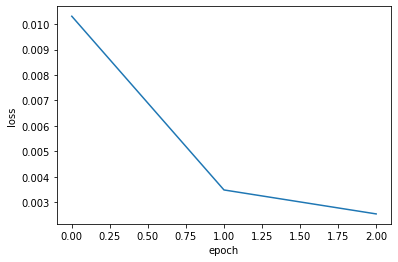

In [24]:
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'])

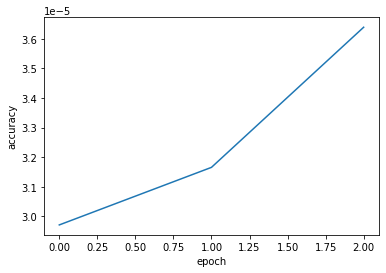

In [25]:
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['accuracy'])

In [29]:
!ls anomaly-model.hdf5

anomaly-model.hdf5


In [84]:
!hdfs dfs -chmod 777 /user/fwaseem/videoanomaly/result

In [20]:
!hdfs dfs -copyToLocal   /user/fwaseem/videoanomaly/models/anomaly-model_v1.hdf5 anomaly-model.hdf5

In [21]:
!hdfs dfs -ls /user/fwaseem/videoanomaly/models/

Found 1 items
-rw-------   3 fwaseem users   23639784 2021-05-12 17:12 /user/fwaseem/videoanomaly/models/anomaly-model_v1.hdf5


In [22]:
loaded_model = tf.keras.models.load_model('anomaly-model.hdf5')

In [23]:
print("faraz 13")

faraz 13


In [59]:
!hdfs dfs -copyFromLocal   /tmp/train*   /user/fwaseem/videoanomaly/result

In [60]:
!hdfs dfs -ls /user/fwaseem/videoanomaly/result/train*

-rw-------   3 fwaseem users       1648 2021-05-17 03:16 /user/fwaseem/videoanomaly/result/train001_pickle.npy
-rw-------   3 fwaseem users       1648 2021-05-17 03:17 /user/fwaseem/videoanomaly/result/train002_pickle.npy
-rw-------   3 fwaseem users       1648 2021-05-17 03:17 /user/fwaseem/videoanomaly/result/train003_pickle.npy
-rw-------   3 fwaseem users       1648 2021-05-17 03:17 /user/fwaseem/videoanomaly/result/train004_pickle.npy
-rw-------   3 fwaseem users       1648 2021-05-17 03:17 /user/fwaseem/videoanomaly/result/train005_pickle.npy
-rw-------   3 fwaseem users       1648 2021-05-17 03:17 /user/fwaseem/videoanomaly/result/train006_pickle.npy
-rw-------   3 fwaseem users       1648 2021-05-17 03:17 /user/fwaseem/videoanomaly/result/train007_pickle.npy
-rw-------   3 fwaseem users       1648 2021-05-17 03:17 /user/fwaseem/videoanomaly/result/train008_pickle.npy
-rw-------   3 fwaseem users       1648 2021-05-17 03:17 /user/fwaseem/videoanomaly/result/train009_pickle.npy
-

got model
got test


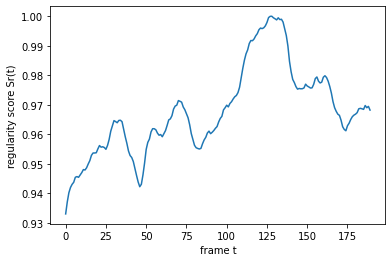

In [58]:
evaluate(BASE + "/Train/Train033", "/tmp/train033_pickle")

In [40]:
!ls /tmp/test25_pickle*

/tmp/test25_pickle.npy


In [43]:
#reading a file in python
tmp25 = np.load("/tmp/test25_pickle.npy")

In [44]:
tmp25

array([0.99545827, 0.99581265, 0.99580097, 0.99616875, 0.99656446,
       0.99759268, 0.99853517, 0.99921081, 0.99845909, 0.99755507,
       0.99614101, 0.99540893, 0.99534626, 0.99571263, 0.99634702,
       0.99753508, 0.99891187, 1.        , 0.99957644, 0.99785888,
       0.99436951, 0.99056555, 0.98639572, 0.9822603 , 0.979693  ,
       0.97678412, 0.9736737 , 0.97179187, 0.97061771, 0.96964811,
       0.96979564, 0.97206242, 0.97318137, 0.97423931, 0.97432867,
       0.97530698, 0.97591831, 0.97487195, 0.97398176, 0.97202853,
       0.96907989, 0.96718519, 0.96632512, 0.96490533, 0.96253208,
       0.96081839, 0.95935576, 0.9599316 , 0.96021675, 0.96240045,
       0.96333933, 0.96303226, 0.96179047, 0.95968752, 0.95813749,
       0.95583202, 0.95468015, 0.95274631, 0.95181633, 0.9496104 ,
       0.9477773 , 0.94653211, 0.94608187, 0.94544815, 0.94390348,
       0.93972199, 0.93710705, 0.93677359, 0.93545948, 0.93311427,
       0.93041173, 0.92839042, 0.92981272, 0.92978578, 0.92857

got model
got test


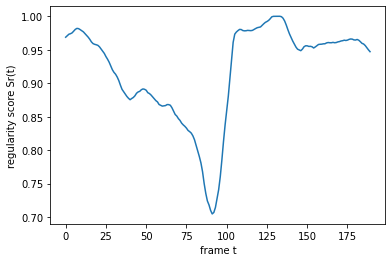

In [80]:
evaluate(BASE + "/Test/Test036", "/tmp/test036_pickle")

got model
got test


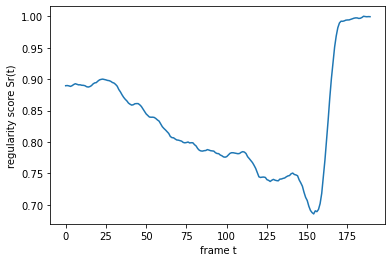

In [60]:
evaluate(BASE + "/Test/Test024")

got model
got test


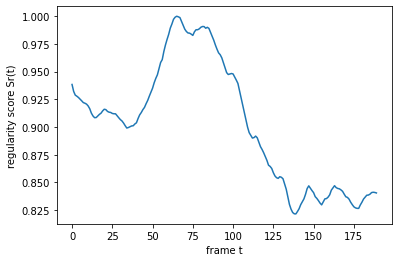

In [61]:
evaluate(BASE + "/Test/Test005")